In [16]:
import cv2
import os

def extract_frames(video_path, output_dir, interval=30):
    """
    Extract frames from a video at specified intervals.
    Args:
        video_path (str): Path to the video file.
        output_dir (str): Directory to save extracted frames.
        interval (int): Frame interval for extraction.
    """
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % interval == 0:
            frame_path = os.path.join(output_dir, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_path, frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count // interval} frames to {output_dir}")


In [ ]:
def yolo_inference(frame_dir, yolo_model):
    """
    Perform YOLOv8 inference on extracted frames.
    Args:
        frame_dir (str): Directory containing frames.
        yolo_model (YOLO): Pre-trained YOLOv8 model.
    Returns:
        list: List of probabilities for each frame.
    """
    import cv2
    import glob

    yolo_probs = []
    frame_paths = sorted(glob.glob(f"{frame_dir}/*.jpg"))

    for frame_path in frame_paths:
        # Load the frame
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Failed to load frame: {frame_path}")
            continue

        # Run YOLO inference
        results = yolo_model(frame)  # Run inference
        if results and results[0].boxes:
            # Extract probabilities for each detection
            frame_probs = [box.conf.item() for box in results[0].boxes]
            yolo_probs.append(frame_probs)
        else:
            yolo_probs.append([])  # No detections
    
    return yolo_probs


In [18]:
import torchvision.transforms as T
from torchvision.transforms.functional import to_tensor
from PIL import Image
import glob
import torch

def rcnn_inference(frame_dir, rcnn_model):
    """
    Perform Fast R-CNN inference on extracted frames.
    Args:
        frame_dir (str): Directory containing frames.
        rcnn_model (nn.Module): Pre-trained Fast R-CNN model.
    Returns:
        list: List of probabilities for each frame.
    """
    rcnn_probs = []
    frame_paths = sorted(glob.glob(f"{frame_dir}/*.jpg"))

    for frame_path in frame_paths:
        try:
            # Load frame as a PIL image
            img = Image.open(frame_path).convert("RGB")

            # Transform image to tensor
            img_tensor = to_tensor(img).unsqueeze(0)  # Add batch dimension

            # Run Fast R-CNN inference
            with torch.no_grad():
                outputs = rcnn_model(img_tensor)
                if outputs and 'scores' in outputs[0]:
                    rcnn_probs.append(outputs[0]['scores'].tolist())  # Collect scores
        except Exception as e:
            print(f"Error processing frame {frame_path}: {e}")
            continue

    return rcnn_probs


In [19]:
import skfuzzy as fuzz
import numpy as np

def fuzzy_decision(yolo_probs, rcnn_probs):
    """
    Combine YOLO and Fast R-CNN probabilities using fuzzy logic.
    Args:
        yolo_probs (list): YOLOv8 probabilities for frames.
        rcnn_probs (list): Fast R-CNN probabilities for frames.
    Returns:
        list: Final activity decisions for each frame.
    """
    x = np.arange(0, 1.1, 0.1)  # Probability range
    yolo_high = fuzz.trimf(x, [0.4, 0.7, 1])
    rcnn_high = fuzz.trimf(x, [0.4, 0.7, 1])

    final_activities = []
    for yolo, rcnn in zip(yolo_probs, rcnn_probs):
        # Fuzzy AND operation
        activity_confidence = fuzz.fuzzy_and(x, yolo_high, x, rcnn_high)[1]
        # Defuzzify to get the final score
        final_score = fuzz.defuzz(x, activity_confidence, 'centroid')
        final_activities.append(final_score)
    return final_activities


In [20]:
def process_video(video_path, yolo_model, rcnn_model, output_dir, interval=30):
    """
    Process a video to recognize activity using YOLOv8, Fast R-CNN, and fuzzy logic.
    Args:
        video_path (str): Path to the input video.
        yolo_model (YOLO): Pre-trained YOLOv8 model.
        rcnn_model (nn.Module): Pre-trained Fast R-CNN model.
        output_dir (str): Directory to save extracted frames.
        interval (int): Number of frames to skip between extractions.
    """
    # Step 1: Extract frames
    print("Extracting frames...")
    extract_frames(video_path, output_dir, interval)

    # Step 2: YOLO Inference
    print("Running YOLO inference on frames...")
    yolo_probs = yolo_inference(output_dir, yolo_model)
    print(f"YOLO Results: {yolo_probs}")

    # Step 3: Fast R-CNN Inference
    print("Running Fast R-CNN inference on frames...")
    rcnn_probs = rcnn_inference(output_dir, rcnn_model)
    print(f"RCNN Results: {rcnn_probs}")

    # Step 4: Apply Fuzzy Logic
    print("Applying fuzzy logic...")
    if not yolo_probs or not rcnn_probs:
        print("Error: No probabilities generated by models.")
        return []

    final_decisions = fuzzy_decision(yolo_probs, rcnn_probs)
    print(f"Final Results: {final_decisions}")

    return final_decisions


In [21]:
if __name__ == "__main__":
    from ultralytics import YOLO
    import torchvision

    # Load pre-trained models
    print("Loading YOLOv8 model...")
    yolo_model = YOLO("yolov8n.pt")  # Replace with your trained YOLOv8 model path

    print("Loading Fast R-CNN model...")
    rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    rcnn_model.eval()

    # Test video path
    video_path = "UCF50_subset/Basketball/v_Basketball_g01_c01.avi"  # Replace with your test video
    output_dir = "frames/Basketball/video1"  # Directory for extracted frames

    # Run the pipeline
    final_results=process_video(video_path, yolo_model, rcnn_model, output_dir)


Loading YOLOv8 model...
Loading Fast R-CNN model...


c:\Users\sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting frames...
Extracted 4 frames to frames/Basketball/video1
Running YOLO inference on frames...

0: 480x640 2 persons, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 59.5ms
Speed: 1.0ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 60.6ms
Speed: 1.0ms preprocess, 60.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 66.5ms
Speed: 2.0ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 69.0ms
Speed: 1.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
YOLO Results: [[0.8861159682273865, 0.804648220539093], [0.8248609900474548, 0.8082901239395142], [0.7965900897979736, 0.7740421295166016], [0.8574105501174927, 0.8043444752693176], [0.8491549491882324, 0.714103102684021]]
Running Fast R-CNN inference on frames

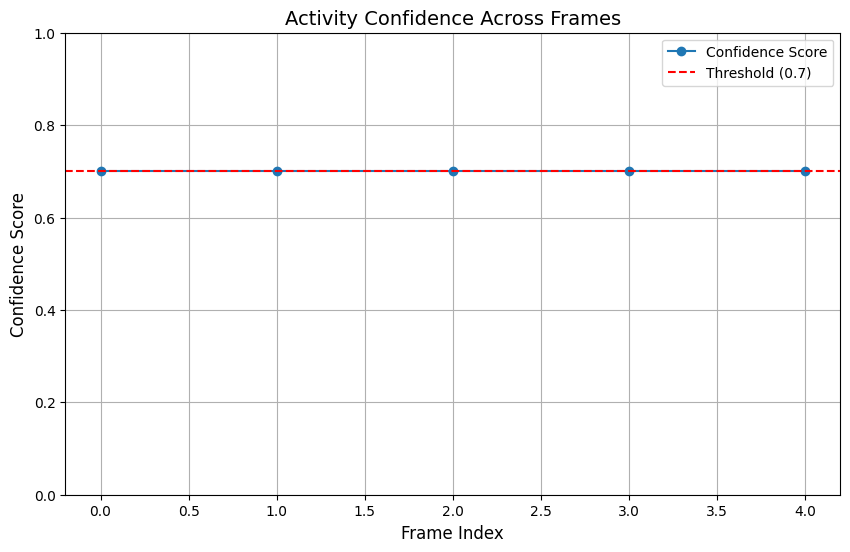

In [22]:
import matplotlib.pyplot as plt

# Final results (confidence scores for each frame)
frame_indices = range(len(final_results))  # Frame indices

plt.figure(figsize=(10, 6))
plt.plot(frame_indices, final_results, marker='o', linestyle='-', label='Confidence Score')
plt.axhline(y=0.7, color='r', linestyle='--', label='Threshold (0.7)')
plt.title("Activity Confidence Across Frames", fontsize=14)
plt.xlabel("Frame Index", fontsize=12)
plt.ylabel("Confidence Score", fontsize=12)
plt.ylim(0, 1)  # Confidence scores range from 0 to 1
plt.legend()
plt.grid(True)
plt.show()


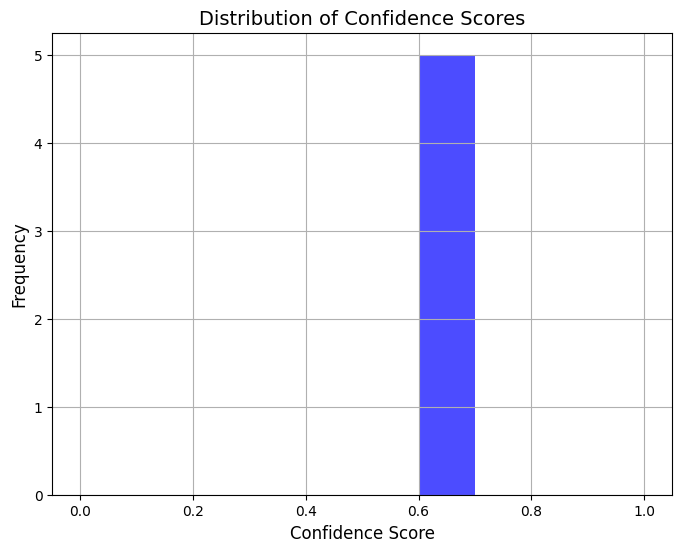

In [ ]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(final_results, bins=10, range=(0, 1), color='blue', alpha=0.7)
plt.title("Distribution of Confidence Scores", fontsize=14)
plt.xlabel("Confidence Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()


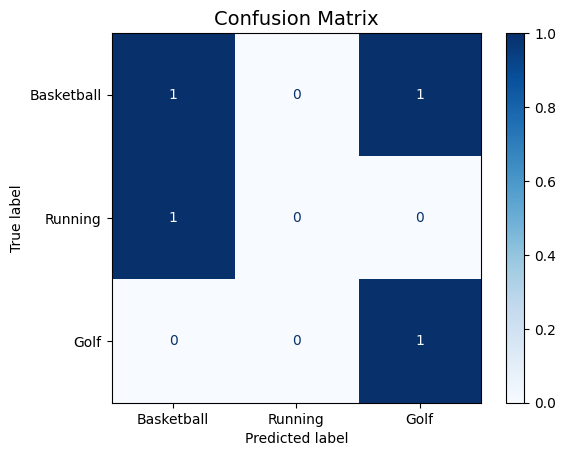

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Replace these with your test data
true_labels = ["Basketball", "Basketball", "Running", "Golf"]
predicted_labels = ["Basketball", "Running", "Running", "Basketball"]

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Basketball", "Running", "Golf"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix", fontsize=14)
plt.show()


In [25]:
def fuzzy_decision(yolo_probs, rcnn_probs, classes):
    final_decisions = []
    final_classes = []
    for yolo, rcnn in zip(yolo_probs, rcnn_probs):
        avg_yolo = sum(yolo) / len(yolo) if yolo else 0
        avg_rcnn = sum(rcnn) / len(rcnn) if rcnn else 0

        # Select class with the highest average confidence
        best_class_idx = (avg_yolo + avg_rcnn).argmax()
        best_class = classes[best_class_idx]

        # Save the confidence and class
        final_decisions.append((avg_yolo + avg_rcnn) / 2)
        final_classes.append(best_class)
    return final_decisions, final_classes


In [26]:
activity_classes = ["Basketball", "Running", "Golf"]
final_results, predicted_classes = fuzzy_decision(yolo_probs, rcnn_probs, activity_classes)


NameError: name 'yolo_probs' is not defined